In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfb = tfp.bijectors
%load_ext autoreload
%autoreload 2
%matplotlib inline
# from tensorflow_probability.python.mcmc import util as mcmc_util
import time
dtype = np.float32

/Users/sharmila/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
from __future__ import division
import argparse
import matplotlib
matplotlib.use('PS')
%matplotlib inline
import tensorflow as tf
import random 
import numpy as np
import os
os.environ['PYTHONHASHSEED'] = '0'

seed = 23
# Setting the seed for numpy-generated random numbers
np.random.seed(seed=seed)

# Setting the seed for python random numbers
random.seed(seed)

# Setting the graph-level random seed.
tf.set_random_seed(seed)

os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.models import Model
from keras.layers import Dense, Activation, Input, concatenate, Lambda, Add
from keras.utils import plot_model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import matplotlib.pyplot as plt 
import GPy
from fipy import *
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 200
import seaborn as sns 
sns.set_context('talk')
sns.set_style('white')
from pdb import set_trace as keyboard
import sys
import time 

/Users/sharmila/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
Using TensorFlow backend.


In [3]:
start = time.time()

In [4]:
FILEPATH = r"my_model_weights.h5"

DNN_type = 'Resnet'
act_func = 'swish'
nx = 100
n = 400
num_block = 3

In [5]:
# ======================
##giving_nn_architecture
# ------------------------------------------------------------
# needs to be defined as activation class otherwise error
# AttributeError: 'Activation' object has no attribute '__name__'    
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})
# ------------------------------------------------------------
# BUILD DNN APPROXIMATOR
# ======================
# DNN network i/p:x,A o/p:prediction

x = Input(shape=(1,))
A = Input(shape=(nx,)) # input field image: conductivity image
a_val = Input(shape=(1,)) # input field value: conductivity value at the corresponding 'input x' location

if DNN_type == 'Resnet':
    x_A = concatenate([x,A])
    o = Dense(n)(x_A)
    for i in range(num_block):
        z = Dense(n, activation = act_func)(o)
        z = Dense(n, activation = act_func)(z)
        o = Add()([z, o])
    prediction = Dense(1)(o)
    print DNN_type

elif DNN_type == 'FC':
    num_neurons_per_layer = map(int, d.strip('[]').split(','))
    x_A = concatenate([x,A])
    z = Dense(num_neurons_per_layer[0], activation=act_func)(x_A)
    for n in num_neurons_per_layer[1:]:
        z = Dense(n, activation=act_func)(z)
    prediction = Dense(1)(z)
    print DNN_type

def myFunc(t):
    B1 = 1 # value_left
    B2 = 0 # value_right
    return ((B1*(1-t[0]))+(B2*t[0])+(t[0]*(1-t[0])*t[1]))

u = Lambda(myFunc, output_shape=(1,))([x,prediction]) # field of interest : temperature
model = Model(inputs=[x,A], outputs=u)

Instructions for updating:
Colocations handled automatically by placer.
Resnet


In [6]:
model.load_weights(FILEPATH) ##loading saved weights of the model

In [7]:
# Data
Xdata = np.array([0.20500000000000002, 0.305, 0.405, 0.505, 0.605, 0.705, 0.805])
Ydata = np.array([0.7633660270634811, 0.7590536094026412, 0.6755348939987039, 0.6433442468899135, 0.6137597421640841, 0.5772112819430778, 0.4909199041904633])
N = len(Xdata)
print(N)

7


In [8]:
# convert data into tf.Tensor 
xdata = tf.cast(Xdata, tf.float32)[:, None]
ydata = tf.cast(Ydata, tf.float32)[:, None]

In [9]:
####logI(\omega) in paper is logxi here
# prior 
prior_logxi = tfd.TruncatedNormal(name= 'logxi', loc=0., scale=tf.ones((nx,)), low=-5.298317366548036*tf.ones((nx,)),high=3.5*tf.ones((nx,)))
                                                                                    # log(0.005000000000000002)=-5.298317366548036
                                                                                    # log(33.11545195869231)=3.5
# noise variance 
LIKE_SCALE = 0.032 # should be selected by tuning by observing if its modelling in the right way.[selected one close to experimental std dev now.]
like_scale = tf.cast(LIKE_SCALE, tf.float32)

#print(rv_xi.sample().shape)
def likelihood_mean(logxi):
    logXi = tf.stack([logxi]*N)
    input_list = [xdata, tf.exp(logXi)]
    ypred = model(input_list)
    return ypred

def unnormalized_log_posterior(logxi):
    logprior = tf.reduce_sum(prior_logxi.log_prob(logxi))
    like_loc = likelihood_mean(logxi)
    like_dist = tfd.Normal(name='like_dist', loc=like_loc, scale=like_scale)
    loglike = tf.reduce_sum(like_dist.log_prob(ydata))
    logjoint_unnorm = loglike + logprior
    return logjoint_unnorm

In [10]:
numsteps = 15000
burn = 2000

# #old
# # https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/HamiltonianMonteCarlo
# # hmckernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=unnormalized_log_posterior, 
# #                                            step_size = 1e-3, 
# #                                           num_leapfrog_steps = 5)

# # samples, kernel_results = tfp.mcmc.sample_chain(num_results=numsteps, 
# #                                                 num_burnin_steps=burn,
# #                                                 num_steps_between_results=10,
# #                                                 current_state=prior_xi.sample(seed=42),
# #                                                 kernel=hmckernel)



# # Create state to hold updated `step_size`.
# step_size = tf.get_variable(
#     name='step_size',
#     initializer=1.,
#     use_resource=True,  # For TFE compatibility.
#     trainable=False)

# hmckernel = tfp.mcmc.HamiltonianMonteCarlo(
#     target_log_prob_fn=unnormalized_log_posterior, 
#     num_leapfrog_steps=3,
#     step_size=step_size,
#     step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
#       num_adaptation_steps=int(burn * 0.8)))

# # Run the chain (with burn-in).
# samples, kernel_results = tfp.mcmc.sample_chain(num_results=numsteps, num_burnin_steps=burn,
#                                                 num_steps_between_results=10,
#                                                 current_state=prior_xi.sample(seed=42),
#                                                 kernel=hmckernel)
#############################################################################################


# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/RandomWalkMetropolis
# rwkkernel=tfp.mcmc.RandomWalkMetropolis(target_log_prob_fn=unnormalized_log_posterior,seed=42)

# samples, kernel_results = tfp.mcmc.sample_chain(num_results=numsteps, 
#                                                 num_burnin_steps=burn,
#                                                 num_steps_between_results=10,
#                                                 current_state=prior_xi.sample(seed=42),
#                                                 kernel=rwkkernel)

# https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/MetropolisAdjustedLangevinAlgorithm
malakernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(target_log_prob_fn=unnormalized_log_posterior,
  step_size=0.3,
  seed=42)

samples, kernel_results = tfp.mcmc.sample_chain(num_results=numsteps, 
                                                num_burnin_steps=burn,
                                                num_steps_between_results=10,
                                                current_state=prior_logxi.sample(seed=42),
                                                kernel=malakernel)


Instructions for updating:
Use tf.cast instead.


In [11]:
# Initialize all constructed variables.
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    init_op.run()
    
    model.load_weights(FILEPATH) ##loading saved weights of the model
    
    samples_, kernel_results_ = sess.run([samples, kernel_results])
#samples_ here are posterior samples i.e. samples of logxi or logI(\omega)
print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    samples_.mean(), samples_.std(), kernel_results_.is_accepted.mean()))

mean:-0.0670  stddev:1.0101  acceptance:0.5855


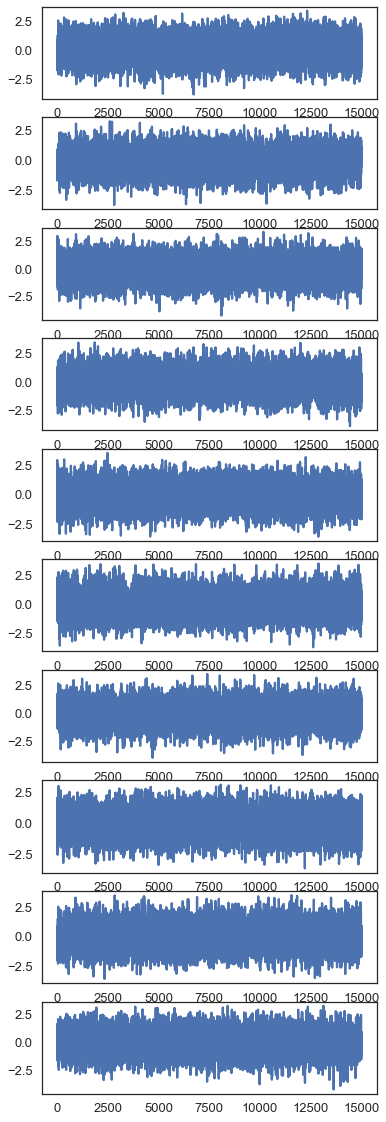

In [12]:
nsamples, nparams = samples_.shape
fig, ax = plt.subplots(10, 1, figsize=(6, 20))
for i in range(10):
    samples_i = samples_[:,i]
    ax[i].plot(samples_i)

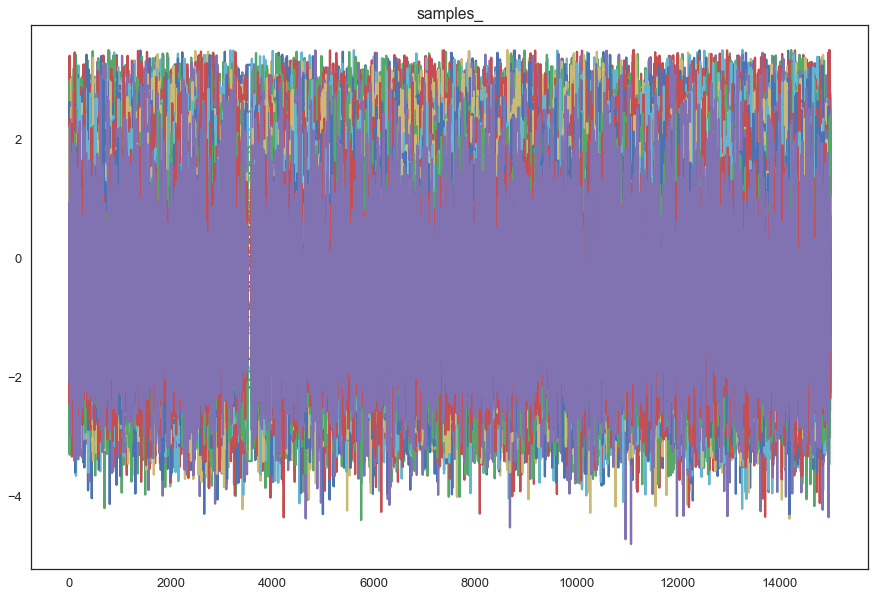

In [13]:
# plotting the mcmc chains
plt.figure(figsize=(15,10))
plt.plot(np.arange(numsteps), (samples_))
plt.title('samples_')

In [14]:
# labels = ['pixels']
# nsamples, nparams = samples_.shape
# # fig, ax = plt.subplots(3, 1, figsize=(6, 20))
# for i in range(nparams):
#     df = pd.DataFrame(samples_[:,i], columns = labels)
#     pd.plotting.scatter_matrix(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x146f0d5d0>]],
      dtype=object)

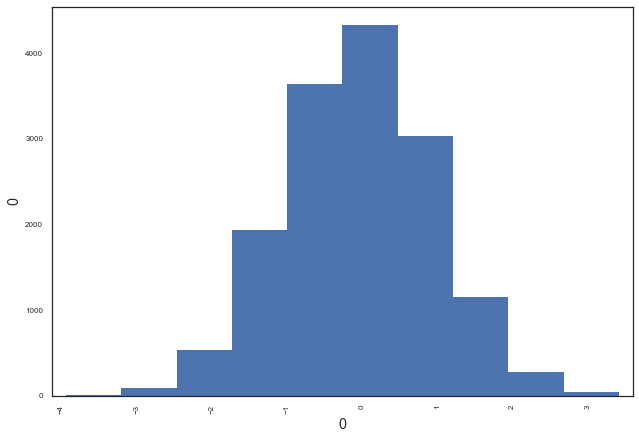

In [15]:
#Scatter plot for the parameters
# import pandas as pd
# df = pd.DataFrame(samples_)
# plt.figure(figsize = (12,12))
# pd.plotting.scatter_matrix(df)

import pandas as pd
df = pd.DataFrame((samples_[:,3]))
plt.figure(figsize = (12,12))
pd.plotting.scatter_matrix(df)

In [16]:
###############################################################
#FIPY solution
value_left = 1
value_right = 0

Lx = 1.  # always put . after 1 
nx = 100
# define mesh
mesh = Grid1D(nx=nx, dx=Lx/nx) # with nx number of cells/cellcenters/pixels/pixelcenters

# define cell and face variables
phi = CellVariable(name='$T(x)$', mesh=mesh, value=0.)
D = CellVariable(name='$D(x)$', mesh=mesh, value=1.0) ## coefficient in diffusion equation
# D = FaceVariable(name='$D(x)$', mesh=mesh, value=1.0) ## coefficient in diffusion equation
source = CellVariable(name='$f(x)$', mesh=mesh, value=1.0)
C = CellVariable(name='$C(x)$', mesh=mesh, value=1.0)

# apply boundary conditions
# dirichet
phi.constrain(value_left, mesh.facesLeft)
phi.constrain(value_right, mesh.facesRight)

# setup the diffusion problem
eq = -DiffusionTerm(coeff=D)+ImplicitSourceTerm(coeff=C) == source

c = 15.
f = 10. #source

source.setValue(f)
C.setValue(c)

x_fipy = mesh.cellCenters.value.T ## fipy solution (nx,1) matrix # same as cellcenters defined above

# x_face=mesh.faceCenters.value.flatten() #cell faces location i.e.edges of the element 

# print ('done1')
###############################################################

In [17]:
def sample_nn(X,nsamples=5):
    """
    nsamples -> Number of samples of the PDE solution to generate.
    """
    samples_nn = np.zeros((nsamples, np.shape(x_fipy)[0]))  ##evaluating at cell centers
    input_field_nn = np.zeros((nsamples, np.shape(x_fipy)[0]))  ##evaluating at cell centers
    
    sess_2 = tf.Session()
    K.set_session(sess_2)
    model.load_weights(FILEPATH) ##loading saved weights of the model
    
    for i in xrange(nsamples):
        Ai = np.exp(X[i])
        uu = sess_2.run(u, feed_dict={x:x_fipy, A:np.repeat(np.array([Ai]), x_fipy.shape[0], axis=0)})
        samples_nn[i] = uu.flatten()
        input_field_nn[i] = Ai
        
    return x_fipy[:,None].flatten(),samples_nn,input_field_nn

In [18]:
Xi_posterior = samples_
# nsamples = np.shape(samples_)[0]
nsamples = 50

X_nn_posterior,U_nn_posterior,INPUT_FIELD_nn_posterior = sample_nn(Xi_posterior,nsamples=nsamples)
mean_nn_posterior = np.mean(U_nn_posterior,axis=0)
var_nn_posterior = np.var(U_nn_posterior,axis=0)

mu_nn_posterior = np.median(U_nn_posterior, axis=0)
mu_025_nn_posterior = np.percentile(U_nn_posterior, 2.5, axis=0)
mu_975_nn_posterior = np.percentile(U_nn_posterior, 97.5, axis=0)

# print np.shape(mu_025_nn_posterior)

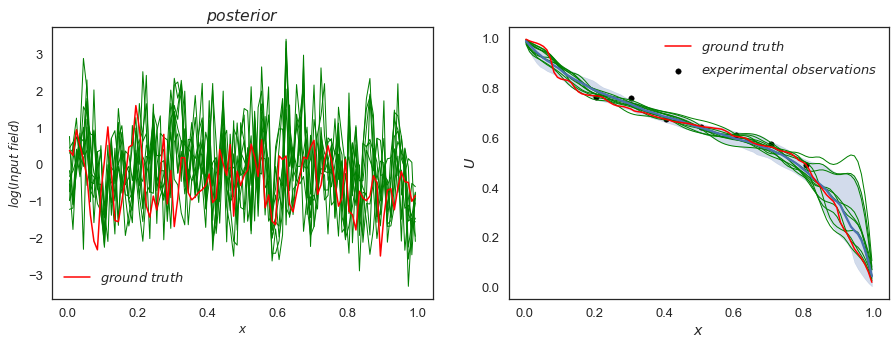

In [19]:
fig = plt.figure(figsize=(15,5))
ax3 = fig.add_subplot(1, 2, 1)
ax4 = fig.add_subplot(1, 2, 2)

# Let's take a couple of samples and see if they fall inside:
nsamples_plot = 10 # just plotting first 5 samples
for i in range(nsamples_plot):
    x_nn_posterior = X_nn_posterior
    u_nn_posterior = U_nn_posterior[i]
    input_field_nn_posterior = INPUT_FIELD_nn_posterior[i]

    ##########
    ax3.plot(x_fipy.flatten(), np.log(input_field_nn_posterior.flatten()), 'g', lw=1)
    ##########
    ax4.plot(x_nn_posterior, u_nn_posterior, 'g', lw=1)

ax3.plot(np.load('xfipy_ground_truth.npy'), np.log(np.load('input_field_ground_truth.npy')[:, None]), 'r', lw=1.5, label=r'$ground \ truth$')   
ax3.set_xlabel('$x$',  fontsize=12)
ax3.set_ylabel(r'$log(Input \ field)$', fontsize=12)
ax3.title.set_text(r'$posterior$')
ax3.legend()

ax4.plot(X_nn_posterior,mu_nn_posterior )
ax4.fill_between(X_nn_posterior,mu_025_nn_posterior,mu_975_nn_posterior, color=sns.color_palette()[0], alpha=0.25)
ax4.plot(np.load('xfipy_ground_truth.npy'), np.load('ufipy_ground_truth.npy'), 'r', lw=1.5, label=r'$ground \ truth$')   
ax4.scatter(Xdata[:,None], Ydata[:,None],s=30,color='black',label=r'$experimental \ observations$')   
ax4.set_xlabel('$x$')
ax4.set_ylabel(r'$U$');
ax4.legend()

# plt.suptitle('posterior')
plt.savefig(os.path.join(os.getcwd(),'posterior_likscale='+str(LIKE_SCALE)+'.pdf'))

In [20]:
print np.shape(samples_) # number of posterior samples

(15000, 100)


In [21]:
# end timer
finish = time.time() - start
print "Time (sec) to complete: " +str(finish)

Time (sec) to complete: 1869.37243485
